In [1]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import viskex

from dolfinx import mesh, io
from mpi4py import MPI

import utils

In [2]:
def get_simulation_metafile_path(Wa_p, kr, gamma, resolution, kinetics="butler_volmer"):
    return os.path.join("output/reaction_distribution/40-40-75", "unrefined", str(resolution), kinetics, f"0.001-{Wa_p}-{kr}", str(gamma), "simulation.json")

In [3]:
def read_simulation_metafile(metafile_path):
    with open(metafile_path, "r") as fp:
        return json.load(fp)

In [4]:
df_rows = []
wagner_nums = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
krs = [0.1, 1.0, 10.0]

for Wa_p in wagner_nums:
    for kr in krs:
        sim_metafile = get_simulation_metafile_path(resolution=1.0, kr=kr, Wa_p=Wa_p, gamma=15)
        try:
            row_data = read_simulation_metafile(sim_metafile)
        except FileNotFoundError:
            print(sim_metafile)
            continue
        df_rows.append(row_data)

df = pd.DataFrame(df_rows, dtype=float)

In [5]:
# df.head()
df.columns

Index(['Negative Wagner Number', 'Positive Wagner Number',
       'Negative Overpotential [V]', 'Positive Overpotential [V]',
       'Open Circuit Potential (OCP) [V]', 'Voltage',
       'interior penalty (gamma)', 'interior penalty kr-modified (gamma)',
       'ionic to electronic conductivity ratio (kr)',
       'average potential left [V]', 'stdev potential left [V]',
       'average potential right [V]', 'stdev potential right [V]',
       'Superficial current density [A/m2]',
       'Current at negative am - electrolyte boundary [A]',
       'Current at electrolyte - positive am boundary [A]',
       'Current at right boundary [A]', 'Current at insulated boundary [A]',
       'stdev i positive charge transfer [A/m2]',
       'stdev i positive charge transfer (normalized)', 'solver atol',
       'solver rtol', 'Total resistance [Ω.cm2]'],
      dtype='object')

In [6]:
utils.make_dir_if_missing("figures/secondary_current/")

### $\frac{\kappa}{\sigma}$ = 0.01

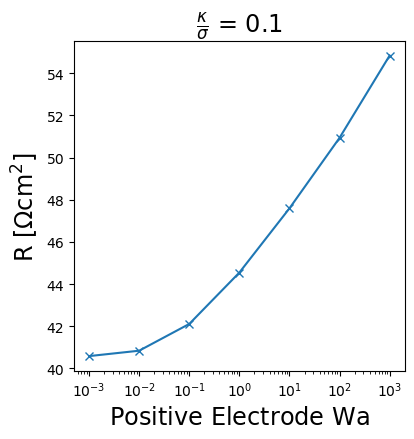

In [7]:
df_001 = df[np.isclose(df["ionic to electronic conductivity ratio (kr)"], 0.1)]
slope_001 = []
x = df_001['Positive Wagner Number'].to_numpy()
y = df_001['Total resistance [Ω.cm2]'].to_numpy()
for i in range(len(wagner_nums) - 1):
    slope_001.append((y[i+1] - y[i])/(x[i+1] - x[i]))
fig, ax = plt.subplots(figsize=(5, 4.5))
ax.plot(df_001['Positive Wagner Number'], df_001['Total resistance [Ω.cm2]'], 'x-')
ax.set_box_aspect(1)
ax.semilogx()
ax.set_ylabel(r'R [$\Omega\mathrm{cm}^2$]', fontdict={'fontsize': 'xx-large'})
ax.set_xlabel(r'$\mathrm{Positive\ Electrode\ Wa}$', fontdict={'fontsize': 'xx-large'})
ax.set_title(r'$\frac{\kappa}{\sigma}$ = 0.1', fontdict={'fontsize': 'xx-large'})
plt.tight_layout()
plt.savefig(f'figures/secondary_current/resistance-kr0.1.png', bbox_inches="tight", dpi=1200)

### $\frac{\kappa}{\sigma}$ = 1

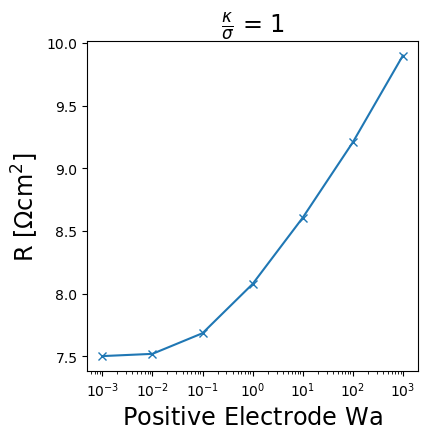

In [8]:
df_1 = df[np.isclose(df["ionic to electronic conductivity ratio (kr)"], 1)]
fig, ax = plt.subplots(figsize=(5, 4.5))
slope_1 = []
x = df_1['Positive Wagner Number'].to_numpy()
y = df_1['Total resistance [Ω.cm2]'].to_numpy()
for i in range(len(wagner_nums) - 1):
    slope_1.append((y[i+1] - y[i])/(x[i+1] - x[i]))
ax.plot(df_1['Positive Wagner Number'], df_1['Total resistance [Ω.cm2]'], 'x-')
ax.set_box_aspect(1)
ax.set_ylabel(r'R [$\Omega\mathrm{cm}^2$]', fontdict={'fontsize': 'xx-large'})
ax.set_xlabel(r'$\mathrm{Positive\ Electrode\ Wa}$', fontdict={'fontsize': 'xx-large'})
ax.semilogx()
ax.set_title(r'$\frac{\kappa}{\sigma}$ = 1', fontdict={'fontsize': 'xx-large'})
plt.tight_layout()
plt.savefig(f'figures/secondary_current/resistance-kr1.png', bbox_inches="tight", dpi=1200)

### $\frac{\kappa}{\sigma}$ = 100

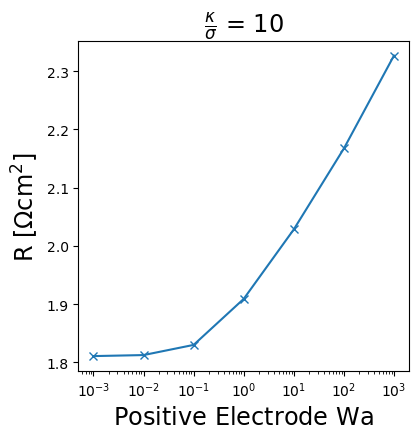

In [9]:
df_100 = df[np.isclose(df["ionic to electronic conductivity ratio (kr)"], 10)]
fig, ax = plt.subplots(figsize=(5, 4.5))
slope_100 = []
x = df_100['Positive Wagner Number'].to_numpy()
y = df_100['Total resistance [Ω.cm2]'].to_numpy()
for i in range(len(wagner_nums) - 1):
    slope_100.append((y[i+1] - y[i])/(x[i+1] - x[i]))
ax.plot(df_100['Positive Wagner Number'], df_100['Total resistance [Ω.cm2]'], 'x-')
ax.set_box_aspect(1)
ax.set_ylabel(r'R [$\Omega\mathrm{cm}^2$]', fontdict={'fontsize': 'xx-large'})
ax.set_xlabel(r'$\mathrm{Positive\ Electrode\ Wa}$', fontdict={'fontsize': 'xx-large'})
ax.semilogx()
ax.set_title(r'$\frac{\kappa}{\sigma}$ = 10', fontdict={'fontsize': 'xx-large'})
plt.tight_layout()
plt.savefig(f'figures/secondary_current/resistance-kr10.png', bbox_inches="tight", dpi=1200)

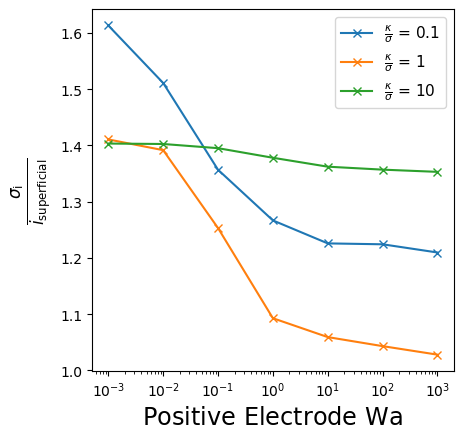

In [10]:
fig, ax = plt.subplots(figsize=(5, 4.5))
ax.plot(df_001['Positive Wagner Number'], df_001['stdev i positive charge transfer (normalized)'], 'x-', label=r'$\frac{\kappa}{\sigma}$ = 0.1')
ax.plot(df_1['Positive Wagner Number'], df_1['stdev i positive charge transfer (normalized)'], 'x-', label=r'$\frac{\kappa}{\sigma}$ = 1')
ax.plot(df_100['Positive Wagner Number'], df_100['stdev i positive charge transfer (normalized)'], 'x-', label=r'$\frac{\kappa}{\sigma}$ = 10')
ax.legend(prop={'size': 11})
ax.semilogx()
ax.set_box_aspect(1)
ax.set_ylabel(r'$\frac{\sigma_{\mathrm{i}}}{i_{\mathrm{superficial}}}$', fontdict={'fontsize': 'xx-large'})
ax.set_xlabel(r'$\mathrm{Positive\ Electrode\ Wa}$', fontdict={'fontsize': 'xx-large'})
plt.tight_layout()
plt.savefig(f'figures/secondary_current/i-stdev-normalized.png', bbox_inches="tight", dpi=1200)

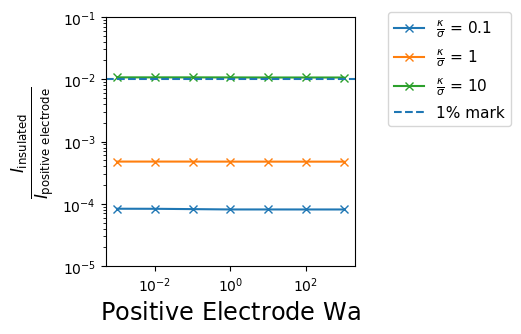

In [11]:
fig, ax = plt.subplots(figsize=(5, 4.5))
ax.plot(df_001['Positive Wagner Number'], df_001['Current at insulated boundary [A]']/df_001['Current at right boundary [A]'], 'x-', label=r'$\frac{\kappa}{\sigma}$ = 0.1')
ax.plot(df_1['Positive Wagner Number'], df_1['Current at insulated boundary [A]']/df_1['Current at right boundary [A]'], 'x-', label=r'$\frac{\kappa}{\sigma}$ = 1')
ax.plot(df_100['Positive Wagner Number'], df_100['Current at insulated boundary [A]']/df_100['Current at right boundary [A]'], 'x-', label=r'$\frac{\kappa}{\sigma}$ = 10')

ax.semilogx()
ax.semilogy()
ax.set_ylim([1e-5, 1e-1])
ax.set_box_aspect(1)
ax.axhline(y=0.01, linestyle='--', label='1% mark')
ax.legend(prop={'size': 11}, bbox_to_anchor=(1.1, 1.05))
ax.set_ylabel(r'$\frac{I_{\mathrm{insulated}}}{I_{\mathrm{positive\ electrode}}}$', fontdict={'fontsize': 'xx-large'})
ax.set_xlabel(r'$\mathrm{Positive\ Electrode\ Wa}$', fontdict={'fontsize': 'xx-large'})
plt.tight_layout()
plt.savefig(f'figures/secondary_current/convergence.png', bbox_inches="tight", dpi=1200)

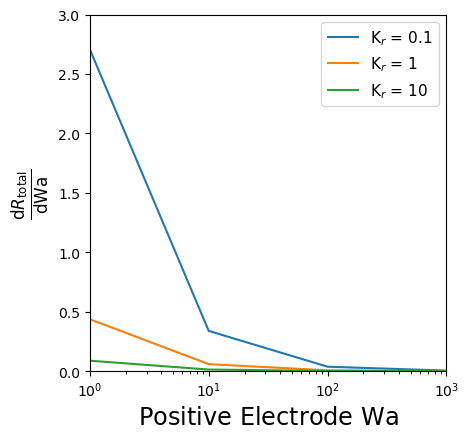

In [31]:
fig, ax = plt.subplots(figsize=(5, 4.5))
ax.plot(x[1:], slope_001, label=r'K$_r$ = 0.1')
ax.plot(x[1:], slope_1, label=r'K$_r$ = 1')
ax.plot(x[1:], slope_100, label=r'K$_r$ = 10')
ax.semilogx()
ax.legend(prop={'size': 11})
ax.set_ylim([0, 3])
ax.set_xlim([1, 1e3]);
ax.set_ylabel(r'$\frac{\mathrm{d}R_{\mathrm{total}}}{\mathrm{d}\mathrm{Wa}}$', fontdict={'fontsize': 'xx-large'})
ax.set_xlabel(r'$\mathrm{Positive\ Electrode\ Wa}$', fontdict={'fontsize': 'xx-large'})
ax.set_box_aspect(1);
plt.tight_layout();
plt.savefig(f'figures/secondary_current/kinetics-limited.png', bbox_inches="tight", dpi=1200)

In [13]:
# comm = MPI.COMM_WORLD
# domain, ct, ft = io.gmshio.read_from_msh("output/reaction_distribution/40-40-75/1.0/mesh.msh", comm)

In [14]:
# viskex.dolfinx.plot_mesh(domain, show_edges=False, opacity=0.5)

In [15]:
# viskex.dolfinx.plot_mesh_tags(domain, ct, show_edges=False, opacity=0.5)

In [16]:
# viskex.dolfinx.plot_mesh_tags(domain, ft, "facets", viskex.utils.values_in([12, 8]), show_edges=False, opacity=1)